In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data processing functions

Esta función realiza la apertura de los archivos CSV y realiza las transformaciones necesarias a los mismos para poder trabajar con ellos adecuadamente, aportando uniformidad a los datos.

In [2]:
def open_csv(df_name):
    """
    Abre un archivo CSV y realiza limpieza y transformación de datos.

    Parámetros:
        df_name (str): El nombre del archivo CSV a abrir.

    Retorna:
        pd.DataFrame: El DataFrame limpiado y transformado.
    """
    # Leer el archivo CSV en un DataFrame.
    # 'keep_default_na=False' evita que se reconozcan valores NA por defecto,
    # y 'na_values=[""]' trata las cadenas vacías como valores NA.
    df = pd.read_csv(df_name, sep=',', keep_default_na=False, na_values=[""])

    # Convertir la columna 'valor' a tipo 'float' con manejo de errores y reemplazar NaN por 0.
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce').fillna(0).astype(float)

    # Renombrar la columna 'periodo' a 'anyo' como en el resto de los archivos.
    df.rename(columns={'periodo': 'anyo'}, inplace=True)
    
    # Convertir la columna 'anyo' a tipo entero.
    df['anyo'] = df['anyo'].astype(int)

    # Ordenar el DataFrame por la columna 'anyo' en orden ascendente.
    df = df.sort_values(by=['anyo'], ascending=True)

    # Eliminar filas donde 'anyo' es 2020 o 2021.
    df = df.drop(df[df['anyo'].isin([2020, 2021])].index)

    # Eliminar filas donde 'entidad' es una isla y no un micro-destino.
    df = df.loc[~df['entidad'].isin(['LANZAROTE', 'FUERTEVENTURA', 'GRAN CANARIA', 'TENERIFE', 'TOTAL'])]
    
    # Eliminar la parte que comienza con '- ' en la columna 'entidad'.
    df['entidad'] = df['entidad'].str.replace(r'^- ', '', regex=True)
    
    # Eliminar duplicados.
    df = df.drop_duplicates()

    return df

Aquí define una función que utiliza un árbol de decisiones para crear rangos para una columna específica en un DataFrame de pandas que se le envié por parámetro, esto nos servirá para extraer la información requerida de cada dataframe, lo cual sera parte de la creación del conjunto de datos experimental. 

In [3]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np

def create_ranges(df, column_name, max_depth=2, decimals=2):
    """
    Crea rangos para una columna en un DataFrame usando un árbol de decisiones.

    Parámetros:
    - df: DataFrame de entrada.
    - column_name: Nombre de la columna para agrupar.
    - max_depth: Profundidad máxima del árbol de decisiones.
    - decimals: Número de decimales para redondear los umbrales.

    Retorna:
    - DataFrame con una nueva columna que contiene los rangos.
    """
    
    # Verificar que column_name exista en el DataFrame.
    # Si no existe, se lanza un error.
    if column_name not in df.columns:
        raise ValueError(f"La columna '{column_name}' no se encuentra en el DataFrame proporcionado.")
    
    # Configurar y entrenar el árbol de decisiones.
    # Utiliza la columna especificada como entrada y salida.
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(df[[column_name]], df[column_name])
    
    # Obtener los umbrales de división del árbol de decisiones.
    # -2 en thresholds indica nodos terminales, por lo que se excluyen.
    thresholds = tree.tree_.threshold
    thresholds = thresholds[thresholds != -2]
    
    # Redondear los umbrales al número de decimales especificado y ordenarlos.
    rounded_thresholds = np.round(thresholds, decimals)
    sorted_thresholds = np.sort(rounded_thresholds)
    
    # Crear los límites de los rangos, incluyendo 0 y infinito como límites externos.
    range_limits = [0] + list(sorted_thresholds) + [np.inf]
    
    # Crear etiquetas para cada rango.
    # Incluye etiquetas especiales para valores menores y mayores a los umbrales.
    intermediate_labels = [f"De {range_limits[i]} a {range_limits[i+1]}" for i in range(1, len(range_limits) - 2)]
    first_label = f"Menor de {range_limits[1]}"
    last_label = f"Mayor de {range_limits[-2]}"
    range_labels = [first_label] + intermediate_labels + [last_label]
    
    # Agrupar los datos en la columna especificada en los rangos definidos.
    # Asigna las etiquetas de rango a cada uno.
    df[column_name] = pd.cut(df[column_name], bins=range_limits, labels=range_labels, right=False)
    
    return df

Esta función se diseñó para filtrar el dataframe por indicadores, cambiar el nombre a las columnas y generar rangos con una llamada a la función anterior.

In [4]:
def create_filtered_ranges(df, indicador, col_name, switch):
    """
    Filtra el DataFrame por un indicador y crea rangos basados en la columna 'valor'.

    Parámetros:
    - df: DataFrame de entrada.
    - indicador: Valor del indicador para filtrar el DataFrame.
    - col_name: Nombre de la columna a renombrar.

    Retorna:
    - DataFrame filtrado con una nueva columna que contiene los rangos.
    """
    
    # Verificar que las columnas 'indicador' y 'valor' existan en el DataFrame.
    # Si no existen, se lanza un error.
    if 'indicador' not in df.columns or 'valor' not in df.columns:
        raise ValueError("El DataFrame no tiene las columnas 'indicador' o 'valor'.")
    
    # Filtrar el DataFrame por el valor de 'indicador' y hacer una copia.
    df_filtered = df[df['indicador'] == indicador].copy()
    
    # Renombrar la columna 'valor' al nombre proporcionado en col_name.
    df_filtered = df_filtered.rename(columns={'valor': col_name})
    
    # Eliminar la columna 'indicador' y reiniciar el índice.
    df_filtered = df_filtered.drop(columns=['indicador']).reset_index(drop=True)
    
    # Si el switch es True, crear rangos para la columna renombrada.
    if switch is True:
        df_filtered = create_ranges(df_filtered, col_name)
    
    return df_filtered

Finalmente, la función process_and_merge procesa el dataframe mediante las funciones anteriores y los une en un único dataframe, que será el del conjunto de datos experimental.

In [5]:
def process_and_merge(df, indicators, switch, base_df=None):
    """
    Genera rangos para cada indicador y une los resultados en un único DataFrame.
    
    Parámetros:
    - df: DataFrame de entrada.
    - indicators: Diccionario con los nombres de los indicadores como claves y los nombres deseados de las columnas como valores.
    - switch: Indica si se deben crear rangos.
    - base_df: DataFrame base para hacer el merge. Si es None, se usa el primero de la lista generada.
    
    Retorna:
    - DataFrame consolidado con columnas de rangos para cada indicador.
    """
    dataframes = []
    
    # Generar un DataFrame para cada indicador y añadirlo a la lista.
    # Dependiendo del valor de 'switch', se crea o no rangos.
    for indicador, col_name in indicators.items():
        df_temp = create_filtered_ranges(df, indicador, col_name, switch)
        dataframes.append(df_temp)
    
    # Determinar el DataFrame base para el merge.
    # Si 'base_df' es None, se utiliza el primer DataFrame de la lista.
    if base_df is None:
        df_merged = dataframes[0]
        start_idx = 1
    else:
        df_merged = base_df.copy()
        start_idx = 0
    
    # Realizar el merge (unión) de DataFrames.
    # Comienza con el DataFrame base y une sucesivamente con los demás.
    # Supone que los DataFrames tienen columnas comunes 'anyo' y 'entidad' para el merge.
    for df_temp in dataframes[start_idx:]:
        df_merged = df_merged.merge(df_temp, on=['anyo', 'entidad'])
    
    return df_merged

## Dataprocessing

En esta parte del proyecto se procesan los datos, empleando las funciones anteriores, para dar forma al conjunto de datos experimental.

In [6]:
# Abrir y procesar el archivo CSV 'microdestinos_ADR_RevPAR_ingresos.csv'
adr_revpar_income = open_csv("microdestinos_ADR_RevPAR_ingresos.csv")

# Reorganizar las columnas del DataFrame para tener un orden específico.
adr_revpar_income = adr_revpar_income.reindex(columns=['anyo', 'indicador', 'entidad', 'valor'])

# Ordenar los datos por año, indicador y entidad en orden ascendente.
adr_revpar_income = adr_revpar_income.sort_values(['anyo', 'indicador', 'entidad'], ascending=[True, True, True])

# Definir un diccionario con los indicadores a procesar.
indicators = {
    'Tarifa media por habitación mensual (ADR)': 'ADR',
    'Ingresos por habitación disponible (RevPAR)': 'RevPAR',
    'Ingresos totales': 'ingresos_totales'
}

# Procesar y combinar los datos para cada indicador.
micro_df = process_and_merge(adr_revpar_income, indicators, False)

# Imprimir el DataFrame resultante para revisión.
print(micro_df)

     anyo                         entidad    ADR  RevPAR  ingresos_totales
0    2009                           Abona  74.43   39.45      4.452629e+07
1    2009                 Adeje turístico  67.38   42.43      2.892784e+08
2    2009                        Amadores  52.88   31.24      3.892153e+07
3    2009  Bahía Feliz - Playa del Águila  54.80   37.14      2.294956e+07
4    2009                 Caleta de Fuste  66.58   36.33      6.189190e+07
..    ...                             ...    ...     ...               ...
699  2019                      Sonnenland  60.47   43.54      3.596657e+07
700  2019                  Taoro - La Paz  59.74   46.41      8.305499e+07
701  2019                         Taurito  92.97   77.38      4.316251e+07
702  2019           Tauro - Playa El Cura  61.37   35.26      1.107844e+07
703  2019         Torviscas - Fañabé Alto  64.21   51.14      3.030332e+07

[704 rows x 5 columns]


In [7]:
# Mapeo de islas a entidades turísticas.
island_entity_mapping = {
    'LANZAROTE': ['Costa Teguise', 'Costa Teguise: Interior', 'Costa Teguise: Litoral', ...],
    'FUERTEVENTURA': ['Caleta de Fuste', 'Corralejo', 'Corralejo - El Cotillo', ...],
    'GRAN CANARIA': ['Mogán turístico', 'Puerto de Mogán', 'Taurito', ...],
    'TENERIFE': ['Adeje turístico', 'Callao Salvaje', 'Playa Paraíso', ...]
}

# Convertir el mapeo de isla a entidad en un diccionario "plano" para facilitar la asignación.
# Cada entidad se asocia directamente con su isla correspondiente.
entity_to_island_map = {entity: island for island, entities in island_entity_mapping.items() for entity in entities}

# Asignar la columna 'isla' en el DataFrame 'df_micro' usando el método .map()
micro_df['isla'] = micro_df['entidad'].map(entity_to_island_map)

# Reorganizar las columnas del DataFrame para un formato específico y ordenarlo.
micro_df = micro_df[['anyo', 'isla', 'entidad', 'ADR', 'RevPAR', 'ingresos_totales']]
micro_df = micro_df.sort_values(['anyo', 'isla'], ascending=[True, True])

# Imprimir el DataFrame resultante para revisión.
print(micro_df)

     anyo           isla                  entidad    ADR  RevPAR  \
4    2009  FUERTEVENTURA          Caleta de Fuste  66.58   36.33   
8    2009  FUERTEVENTURA                Corralejo  57.58   35.00   
9    2009  FUERTEVENTURA   Corralejo - El Cotillo  57.23   34.49   
48   2009   GRAN CANARIA          Puerto de Mogán  67.35   36.12   
61   2009   GRAN CANARIA                  Taurito  55.88   30.19   
..    ...            ...                      ...    ...     ...   
698  2019            NaN              San Agustín  94.61   66.05   
699  2019            NaN               Sonnenland  60.47   43.54   
700  2019            NaN           Taoro - La Paz  59.74   46.41   
702  2019            NaN    Tauro - Playa El Cura  61.37   35.26   
703  2019            NaN  Torviscas - Fañabé Alto  64.21   51.14   

     ingresos_totales  
4         61891895.02  
8         67969665.09  
9         68649877.70  
48         9696842.87  
61        14690544.38  
..                ...  
698       53638

In [8]:
# Leer y procesar el archivo CSV 'microdestinos_tasa_ocupacion.csv'.
occupation_rate = open_csv("microdestinos_tasa_ocupacion.csv")

# Definir un diccionario para los indicadores de tasa de ocupación.
indicators_to = {
    'Tasa de ocupación por habitaciones-apartamentos': 'tasa_ocup_h',
    'Tasa de ocupación por plazas': 'tasa_ocup_p'
}

# Procesar y combinar los datos de tasa de ocupación con el DataFrame 'df_micro'.
micro_df = process_and_merge(occupation_rate, indicators_to, False, micro_df)

# Imprimir el DataFrame resultante para revisión.
print(micro_df)

     anyo           isla                  entidad    ADR  RevPAR  \
0    2009  FUERTEVENTURA          Caleta de Fuste  66.58   36.33   
1    2009  FUERTEVENTURA                Corralejo  57.58   35.00   
2    2009  FUERTEVENTURA   Corralejo - El Cotillo  57.23   34.49   
3    2009   GRAN CANARIA          Puerto de Mogán  67.35   36.12   
4    2009   GRAN CANARIA                  Taurito  55.88   30.19   
..    ...            ...                      ...    ...     ...   
699  2019            NaN              San Agustín  94.61   66.05   
700  2019            NaN               Sonnenland  60.47   43.54   
701  2019            NaN           Taoro - La Paz  59.74   46.41   
702  2019            NaN    Tauro - Playa El Cura  61.37   35.26   
703  2019            NaN  Torviscas - Fañabé Alto  64.21   51.14   

     ingresos_totales  tasa_ocup_h  tasa_ocup_p  
0         61891895.02        54.57        40.85  
1         67969665.09        60.79        50.46  
2         68649877.70        60.2

In [9]:
# Leer y procesar el archivo CSV 'microdestinos_pernoctaciones_viajeros_entradas.csv'.
overnights_visitors_entries_df = open_csv("microdestinos_pernoctaciones_viajeros_entradas.csv")

# Filtrar el DataFrame para incluir solo las filas donde el 'origen' es 'TOTAL'.
# Se elimina la columna 'origen' ya que no se necesita después del filtrado.
overnights_visitors_entries_df = overnights_visitors_entries_df.loc[overnights_visitors_entries_df['origen'] == 'TOTAL']
overnights_visitors_entries_df.drop('origen', axis=1, inplace=True)

# Definir un diccionario para los indicadores de pernoctaciones, viajeros alojados y entrados.
indicators = {
    'Pernoctaciones': 'pernoctaciones',
    'Viajeros alojados': 'alojados',
    'Viajeros entrados': 'entrados'
}

# Procesar y combinar los datos con el DataFrame 'df_micro_to'.
micro_df = process_and_merge(overnights_visitors_entries_df, indicators, False, micro_df)

# Imprimir el DataFrame resultante para revisión.
print(micro_df)

     anyo           isla                  entidad    ADR  RevPAR  \
0    2009  FUERTEVENTURA          Caleta de Fuste  66.58   36.33   
1    2009  FUERTEVENTURA                Corralejo  57.58   35.00   
2    2009  FUERTEVENTURA   Corralejo - El Cotillo  57.23   34.49   
3    2009   GRAN CANARIA          Puerto de Mogán  67.35   36.12   
4    2009   GRAN CANARIA                  Taurito  55.88   30.19   
..    ...            ...                      ...    ...     ...   
699  2019            NaN              San Agustín  94.61   66.05   
700  2019            NaN               Sonnenland  60.47   43.54   
701  2019            NaN           Taoro - La Paz  59.74   46.41   
702  2019            NaN    Tauro - Playa El Cura  61.37   35.26   
703  2019            NaN  Torviscas - Fañabé Alto  64.21   51.14   

     ingresos_totales  tasa_ocup_h  tasa_ocup_p  pernoctaciones  alojados  \
0         61891895.02        54.57        40.85       1792019.0  246084.0   
1         67969665.09        

## First Test

Esta parte del proyecto se realizó con el objetivo de tener una visión general del contenido del conjunto.

In [10]:
# Obtener y mostrar información detallada sobre el DataFrame 'micro_df'.
# Esta información incluye:
# - El número total de entradas y columnas.
# - El tipo de dato de cada columna.
# - La cantidad de memoria utilizada.
# - Información sobre valores no nulos en cada columna.
micro_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704 entries, 0 to 703
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anyo              704 non-null    int32  
 1   isla              121 non-null    object 
 2   entidad           704 non-null    object 
 3   ADR               704 non-null    float64
 4   RevPAR            704 non-null    float64
 5   ingresos_totales  704 non-null    float64
 6   tasa_ocup_h       704 non-null    float64
 7   tasa_ocup_p       704 non-null    float64
 8   pernoctaciones    704 non-null    float64
 9   alojados          704 non-null    float64
 10  entrados          704 non-null    float64
dtypes: float64(8), int32(1), object(2)
memory usage: 63.2+ KB


El proceso de Label Encoding es crucial en la preparación de datos para modelos de aprendizaje automático, ya que muchos algoritmos requieren que todas las entradas sean numéricas. Este código transforma las columnas categóricas en representaciones numéricas, facilitando su uso en análisis posteriores o en algoritmos de aprendizaje automático.

In [11]:
# Importar LabelEncoder de sklearn para codificación de etiquetas
from sklearn.preprocessing import LabelEncoder

# Crear una copia del DataFrame original 'micro_df'.
encoded_df = micro_df.copy()

# Inicializar el LabelEncoder.
labelencoder = LabelEncoder()

# Aplicar Label Encoding a cada columna no numérica.
for col in encoded_df.select_dtypes(include=['object', 'category']).columns:
    encoded_df[col] = labelencoder.fit_transform(encoded_df[col])

# Imprimir el DataFrame después de aplicar Label Encoding para revisión.
# Las columnas categóricas ahora estarán representadas como números enteros.
print(encoded_df)

     anyo  isla  entidad    ADR  RevPAR  ingresos_totales  tasa_ocup_h  \
0    2009     0        4  66.58   36.33       61891895.02        54.57   
1    2009     0        8  57.58   35.00       67969665.09        60.79   
2    2009     0        9  57.23   34.49       68649877.70        60.28   
3    2009     1       48  67.35   36.12        9696842.87        53.59   
4    2009     1       61  55.88   30.19       14690544.38        54.08   
..    ...   ...      ...    ...     ...               ...          ...   
699  2019     4       58  94.61   66.05       53638349.20        69.97   
700  2019     4       59  60.47   43.54       35966571.46        72.20   
701  2019     4       60  59.74   46.41       83054987.35        77.89   
702  2019     4       62  61.37   35.26       11078435.43        57.65   
703  2019     4       63  64.21   51.14       30303315.42        79.86   

     tasa_ocup_p  pernoctaciones  alojados  entrados  
0          40.85       1792019.0  246084.0  239461.0  
1

Este bloque de código realiza la visualización de la matriz de correlación de Spearman, utilizando las bibliotecas Seaborn y Matplotlib para la representación gráfica.

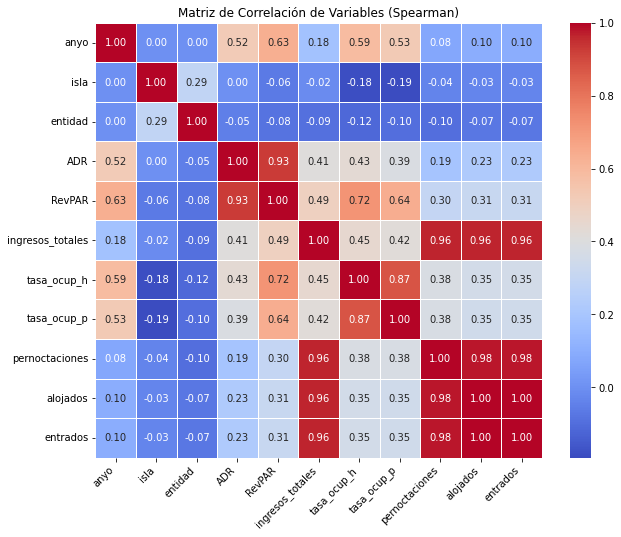

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación de Spearman para el DataFrame 'df_encoded'.
correlation_matrix_spearman = encoded_df.corr(method='spearman')

# Visualizar la matriz de correlación utilizando un mapa de calor de Seaborn.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, ax=ax)

# Ajustar las etiquetas y los ticks de los ejes para mejorar la legibilidad.
ax.set_xticklabels(correlation_matrix_spearman.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix_spearman.columns)

# Añadir un título al gráfico para identificar el contenido visualizado.
plt.title("Matriz de Correlación de Variables (Spearman)")

# Mostrar el gráfico de mapa de calor.
plt.show()

Crear gráficos de dispersión individuales para cada variable en relación con el año es una excelente manera de visualizar tendencias y patrones en los datos a lo largo del tiempo.

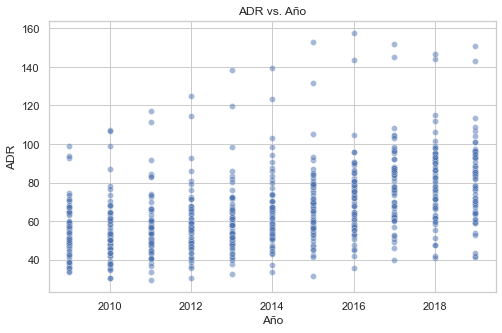

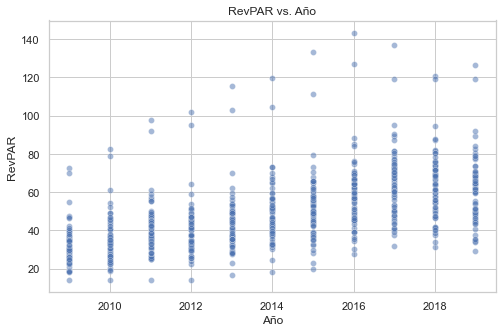

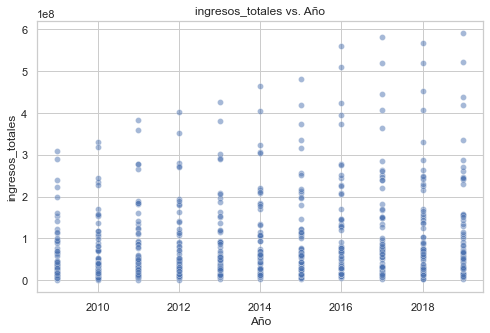

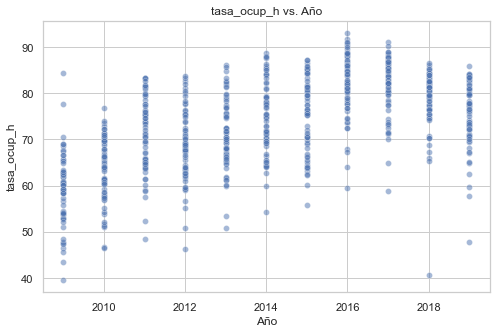

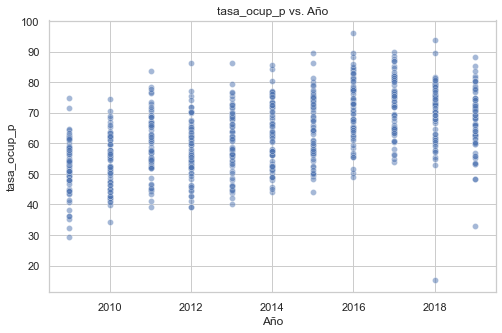

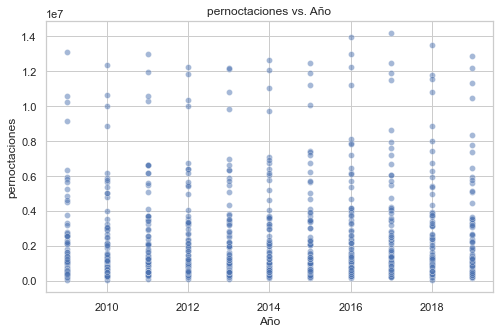

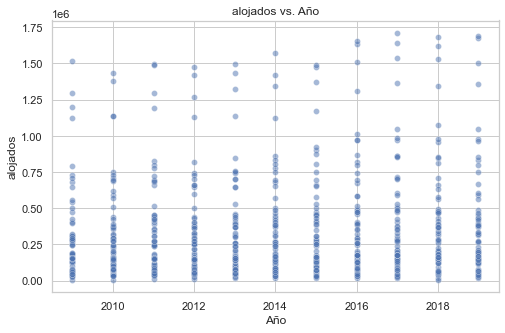

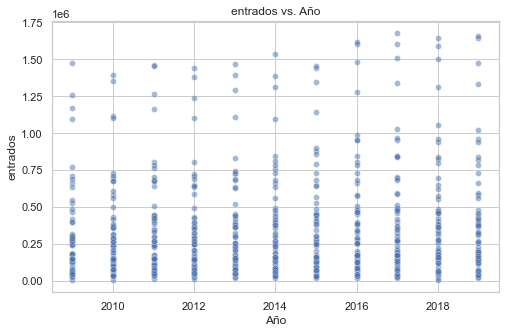

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir una lista de variables para las que se crearán gráficos de dispersión.
variables = ['ADR', 'RevPAR', 'ingresos_totales', 'tasa_ocup_h', 'tasa_ocup_p', 'pernoctaciones', 'alojados', 'entrados']

# Establecer el estilo de fondo del gráfico a 'whitegrid' para mejorar la visibilidad y estética.
sns.set(style="whitegrid")

# Crear un gráfico de dispersión para cada variable en la lista en relación con 'anyo'.
for variable in variables:
    # Configurar el tamaño de cada gráfico individual.
    plt.figure(figsize=(8, 5))
    # Crear el gráfico de dispersión utilizando Seaborn, con una transparencia del 50%.
    sns.scatterplot(data=encoded_df, x='anyo', y=variable, alpha=0.5)
    # Añadir un título al gráfico indicando la variable y el año.
    plt.title(f'{variable} vs. Año')
    # Etiquetar los ejes x e y para claridad.
    plt.xlabel('Año')
    plt.ylabel(variable)
    # Mostrar el gráfico resultante.
    plt.show()

Este bloque de código crea gráficos de dispersión individuales para una serie de variables en relación con el año, utilizando la biblioteca Seaborn para la visualización. 

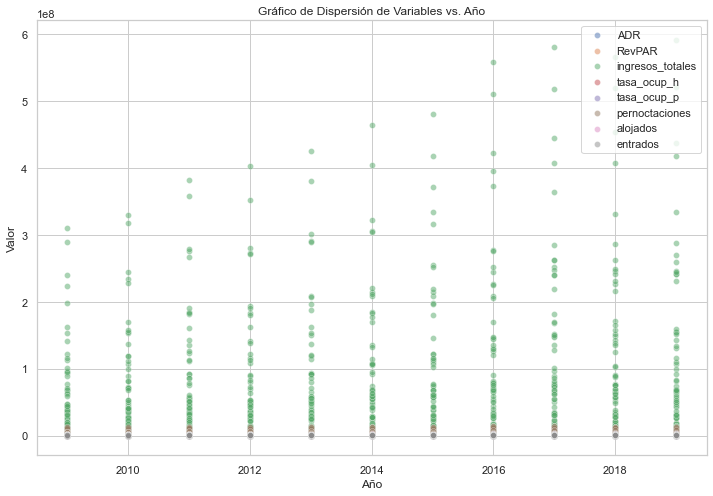

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir la lista de variables para crear gráficos de dispersión.
variables = ['ADR', 'RevPAR', 'ingresos_totales', 'tasa_ocup_h', 'tasa_ocup_p', 'pernoctaciones', 'alojados', 'entrados']

# Configurar el estilo del gráfico a 'whitegrid' para un fondo con líneas de cuadrícula.
sns.set(style="whitegrid")

# Crear una figura de tamaño (12, 8) para todos los gráficos de dispersión.
plt.figure(figsize=(12, 8))

# Iterar a través de cada variable y agregarla al gráfico de dispersión.
for variable in variables:
    # Agregar la variable al gráfico con transparencia (alpha=0.5) y etiqueta.
    sns.scatterplot(data=encoded_df, x='anyo', y=variable, label=variable, alpha=0.5)

# Establecer el título, etiquetas de ejes y mostrar la leyenda.
plt.title('Gráfico de Dispersión de Variables vs. Año')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.legend(loc='upper right')

# Mostrar el gráfico de dispersión combinado.
plt.show()

El código proporcionado está diseñado para visualizar las tendencias de las variables 'ADR' y 'RevPAR' a lo largo del tiempo para una entidad específica seleccionada.

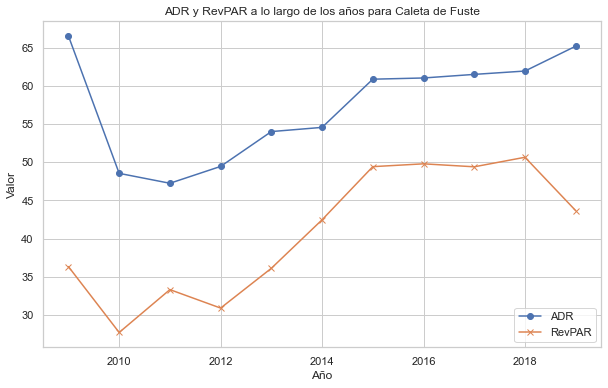

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar el DataFrame 'micro_df' por una entidad específica para simplificar el análisis del gráfico.
selected_entity = 'Caleta de Fuste'  # Cambia esto por la entidad que desees visualizar.
filtered_df = micro_df[micro_df['entidad'] == selected_entity]

# Crear una figura para el gráfico con un tamaño definido.
plt.figure(figsize=(10, 6))

# Dibujar líneas para ADR y RevPAR en función del año.
# Se utilizan diferentes marcadores para distinguir cada línea.
plt.plot(filtered_df['anyo'], filtered_df['ADR'], label='ADR', marker='o')
plt.plot(filtered_df['anyo'], filtered_df['RevPAR'], label='RevPAR', marker='x')

# Añadir título, etiquetas para los ejes, leyenda y activar la cuadrícula para facilitar la lectura.
plt.title(f'ADR y RevPAR a lo largo de los años para {selected_entity}')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

# Mostrar el gráfico resultante.
plt.show()

En este bloque se crea un gráfico de líneas para visualizar las tendencias de los ingresos totales y la tasa de ocupación en habitaciones a lo largo de los años para una isla específica seleccionada de un DataFrame. 

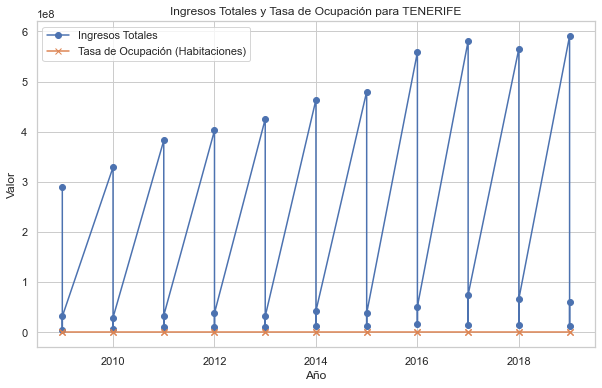

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar el DataFrame 'micro_df' por una isla específica para simplificar el análisis del gráfico.
selected_island = 'TENERIFE'  # Cambiar por la isla que se desee visualizar.
filtered_df = micro_df[micro_df['isla'] == selected_island]

# Crear una figura para el gráfico con un tamaño definido.
plt.figure(figsize=(10, 6))

# Dibujar líneas para los ingresos totales y la tasa de ocupación en habitaciones en función del año.
plt.plot(filtered_df['anyo'], filtered_df['ingresos_totales'], label='Ingresos Totales', marker='o')
plt.plot(filtered_df['anyo'], filtered_df['tasa_ocup_h'], label='Tasa de Ocupación (Habitaciones)', marker='x')

# Añadir título, etiquetas para los ejes, leyenda y activar la cuadrícula para facilitar la lectura.
plt.title(f'Ingresos Totales y Tasa de Ocupación para {selected_island}')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)

# Mostrar el gráfico resultante.
plt.show()

Se crea un gráfico de dispersión para visualizar y comparar las tendencias de ingresos totales y tasas de ocupación a lo largo de los años para diferentes islas en un DataFrame.

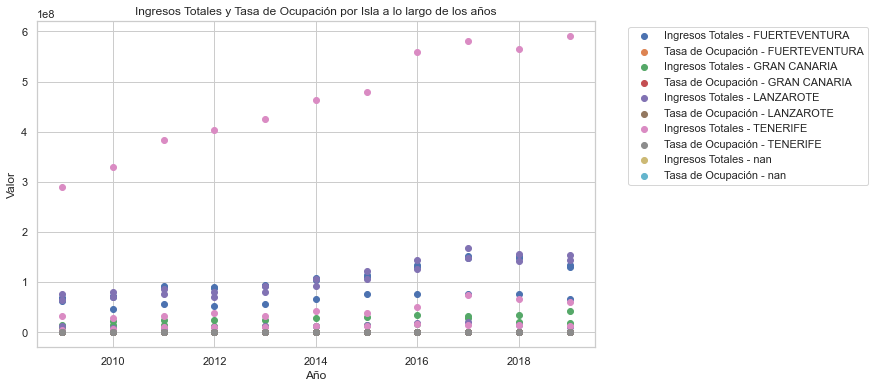

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear una figura para el gráfico con un tamaño definido.
plt.figure(figsize=(10, 6))

# Iterar sobre cada isla única en el DataFrame 'micro_df'.
for isla in micro_df['isla'].unique():
    # Filtrar el DataFrame para cada isla.
    df_isla = micro_df[micro_df['isla'] == isla]
    
    # Crear gráficos de dispersión para ingresos totales y tasa de ocupación de cada isla.
    # Utilizar etiquetas para diferenciar entre las islas.
    plt.scatter(df_isla['anyo'], df_isla['ingresos_totales'], label=f'Ingresos Totales - {isla}')
    plt.scatter(df_isla['anyo'], df_isla['tasa_ocup_h'], label=f'Tasa de Ocupación - {isla}')

# Añadir título, etiquetas para los ejes y leyenda al gráfico.
# La leyenda se coloca fuera del área de trazado para no obstruir los datos.
plt.title('Ingresos Totales y Tasa de Ocupación por Isla a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Activar la cuadrícula para una mejor lectura del gráfico.
plt.grid(True)

# Mostrar el gráfico resultante.
plt.show()

Se genera un gráfico de barras comparativo para visualizar la evolución anual de la tasa media de ocupación por habitación para diferentes islas.

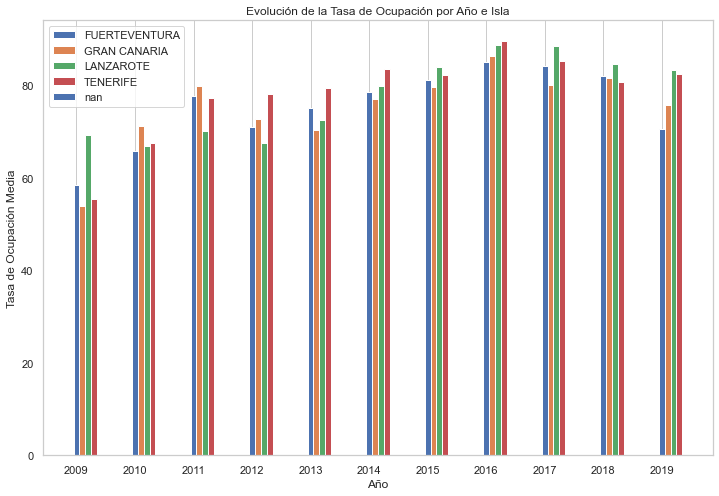

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Configurar el tamaño de la figura del gráfico.
plt.figure(figsize=(12, 8))

# Iterar sobre cada isla única en el DataFrame 'micro_df'.
for isla in micro_df['isla'].unique():
    # Filtrar el DataFrame para cada isla.
    df_isla = micro_df[micro_df['isla'] == isla]
    
    # Calcular la media anual de la tasa de ocupación por habitación para cada isla.
    media_tasa_ocupacion = df_isla.groupby('anyo')['tasa_ocup_h'].mean()
    
    # Crear un gráfico de barras para cada isla.
    # Se ajusta la posición de las barras para evitar solapamientos.
    plt.bar(media_tasa_ocupacion.index + (0.1 * list(micro_df['isla'].unique()).index(isla)), 
            media_tasa_ocupacion.values, width=0.1, label=isla)

# Añadir título, etiquetas para los ejes y leyenda al gráfico.
plt.title('Evolución de la Tasa de Ocupación por Año e Isla')
plt.xlabel('Año')
plt.ylabel('Tasa de Ocupación Media')

# Configurar las marcas del eje x para que muestren todos los años.
plt.xticks(micro_df['anyo'].unique())

# Añadir una leyenda para identificar las islas y una cuadrícula en el eje y para facilitar la comparación.
plt.legend()
plt.grid(axis='y')

# Mostrar el gráfico resultante.
plt.show()

Crear un mapa de calor utilizando Seaborn y Matplotlib para visualizar los datos faltantes 

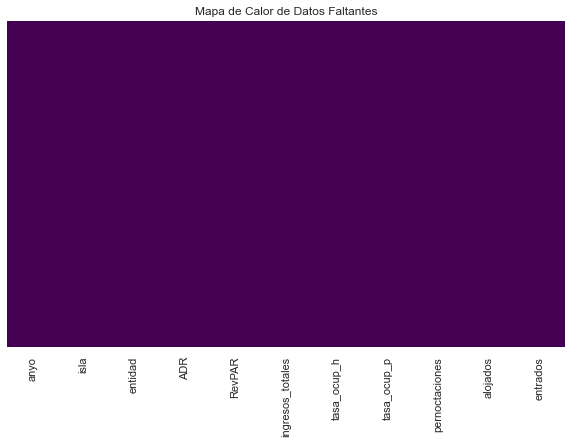

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura del gráfico a 10x6 pulgadas.
plt.figure(figsize=(10, 6))

# Utilizar Seaborn para crear un mapa de calor de los datos faltantes, se emplea df_encoded ya que cuenta con todas las variables numéricas.
sns.heatmap(encoded_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

# Añadir un título al gráfico para identificar el contenido visualizado.
plt.title('Mapa de Calor de Datos Faltantes')

# Mostrar el gráfico resultante.
plt.show()


## Outliers Functions

Para la gestion de outliers.

### Standard Deviations Method

In [20]:
import pandas as pd

def outliers_std(df, variables, threshold_std=3):
    """
    Identifica valores atípicos en un DataFrame basándose en la desviación estándar.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        variables (list): Lista de nombres de columnas para buscar outliers.
        threshold_std (int, optional): Número de desviaciones estándar para determinar los límites. Por defecto es 3.

    Returns:
        pd.DataFrame: DataFrame que contiene solo las filas con outliers.
    """
    df_outliers = pd.DataFrame()

    for variable in variables:
        # Calcular la media y desviación estándar de la variable actual.
        mean = df[variable].mean()
        std_dev = df[variable].std()
        
        # Establecer límites superior e inferior basados en la desviación estándar.
        upper_limit = mean + threshold_std * std_dev
        lower_limit = mean - threshold_std * std_dev
        
        # Filtrar los outliers fuera de los límites superior e inferior.
        outliers = df[(df[variable] < lower_limit) | (df[variable] > upper_limit)]
        df_outliers = pd.concat([df_outliers, outliers])

    # Eliminar duplicados y reiniciar el índice.
    df_outliers = df_outliers.drop_duplicates().reset_index(drop=True)
    return df_outliers

### IQR Method

In [21]:
import pandas as pd

def outliers_iqr(df, variables, threshold_iqr=1.5):
    """
    Identifica valores atípicos en un DataFrame utilizando el rango intercuartílico (IQR).

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        variables (list): Lista de nombres de columnas para buscar outliers.
        threshold_iqr (float, optional): Multiplicador para el IQR para determinar los límites. Por defecto es 1.5.

    Returns:
        pd.DataFrame: DataFrame que contiene solo las filas con outliers.
    """
    df_outliers = pd.DataFrame()

    for variable in variables:
        # Calcular el primer y tercer cuartil (Q1 y Q3).
        Q1 = df[variable].quantile(0.25)
        Q3 = df[variable].quantile(0.75)
        IQR = Q3 - Q1
        
        # Establecer límites superior e inferior basados en el IQR.
        upper_limit = Q3 + threshold_iqr * IQR
        lower_limit = Q1 - threshold_iqr * IQR
        
        # Filtrar los outliers que están fuera de los límites superior e inferior.
        outliers = df[(df[variable] < lower_limit) | (df[variable] > upper_limit)]
        df_outliers = pd.concat([df_outliers, outliers])

    # Eliminar duplicados y reiniciar el índice.
    df_outliers = df_outliers.drop_duplicates().reset_index(drop=True)
    return df_outliers

###  Clustering Method (K-Means)

In [22]:
from sklearn.cluster import KMeans
import pandas as pd

def outliers_kmeans(df, variables, n_clusters=2, n_init=10):
    """
    Identifica valores atípicos en un DataFrame utilizando el algoritmo K-Means.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        variables (list): Lista de nombres de columnas para buscar outliers.
        n_clusters (int, optional): Número de clusters a formar. Por defecto es 2.
        n_init (int, optional): Número de veces que el algoritmo K-Means se ejecutará con diferentes semillas de centroides. Por defecto es 10.

    Returns:
        pd.DataFrame: DataFrame que contiene solo las filas identificadas como outliers.
    """
    df_outliers = pd.DataFrame()
    df = df.copy()

    for variable in variables:
        # Aplicar el algoritmo K-Means a la variable actual.
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init)
        df['cluster'] = kmeans.fit_predict(df[[variable]])
        
        # Identificar el cluster con menos elementos como el cluster de outliers.
        outlier_cluster = df['cluster'].value_counts().idxmin()
        
        # Seleccionar las filas que pertenecen al cluster de outliers.
        outliers = df[df['cluster'] == outlier_cluster]
        
        # Agregar los outliers detectados al DataFrame de outliers.
        df_outliers = pd.concat([df_outliers, outliers])

    # Eliminar la columna 'cluster' y los duplicados, y reiniciar el índice.
    df_outliers = df_outliers.drop(columns=['cluster']).drop_duplicates().reset_index(drop=True)
    return df_outliers

###  Isolation Forest Method

In [23]:
from sklearn.ensemble import IsolationForest
import pandas as pd

def outliers_iforest(df, variables, contamination=0.05):
    """
    Identifica valores atípicos en un DataFrame utilizando el algoritmo Isolation Forest.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        variables (list): Lista de nombres de columnas para buscar outliers.
        contamination (float, optional): Proporción de outliers en los datos. Por defecto es 0.05.

    Returns:
        pd.DataFrame: DataFrame que contiene solo las filas identificadas como outliers.
    """
    df_outliers = pd.DataFrame()
    df = df.copy()

    for variable in variables:
        # Aplicar Isolation Forest a la variable actual.
        isolation_forest = IsolationForest(contamination=contamination)
        
        # Agregar una columna para marcar los outliers.
        df[variable + '_outlier'] = isolation_forest.fit_predict(df[[variable]])
        
        # Filtrar y seleccionar solo las filas marcadas como outliers.
        outliers = df[df[variable + '_outlier'] == -1]
        df_outliers = pd.concat([df_outliers, outliers])

    # Eliminar las columnas auxiliares usadas para marcar outliers.
    for variable in variables:
        df_outliers = df_outliers.drop(columns=[variable + '_outlier'])

    # Eliminar duplicados y reiniciar el índice.
    df_outliers = df_outliers.drop_duplicates().reset_index(drop=True)
    return df_outliers

### Find Matches between Methods

In [24]:
def find_matches(df, variables):
    """
    Finds and removes outliers identified by multiple detection methods.

    Args:
        df (pd.DataFrame): Input DataFrame.
        variables (list): List of column names to search for outliers.

    Returns:
        pd.DataFrame: DataFrame without outliers detected by all methods.
    """
    # Detect outliers using standard deviation method.
    std_outliers_df = outliers_std(df, variables)
    
    # Detect outliers using the Interquartile Range (IQR) method.
    iqr_outliers_df = outliers_iqr(df, variables)
    
    # Detect outliers using K-Means.
    kmeans_outliers_df = outliers_kmeans(df, variables)
    
    # Detect outliers using Isolation Forest.
    iforest_outliers_df = outliers_iforest(df, variables)

    # Combine results from all four methods and find rows that are outliers in all.
    matches_df = pd.concat([std_outliers_df, iqr_outliers_df, kmeans_outliers_df, iforest_outliers_df])
    matches_df = matches_df[matches_df.duplicated(keep=False)].reset_index(drop=True)
    
    # Identify indices of matching rows in the original DataFrame.
    matching_indices = df[df.isin(matches_df.to_dict(orient='list'))].dropna().index.unique()

    # Return the original DataFrame excluding identified outliers.
    without_outliers_df = df.drop(matching_indices).reset_index(drop=True)
    
    # If 'cluster' column exists, remove it from the resulting DataFrame.
    if 'cluster' in without_outliers_df.columns:
        without_outliers_df= without_outliers_df.drop('cluster', axis=1)

    return without_outliers_df

In [25]:
# Definir una lista de variables para la detección de outliers.
variables = ['ADR', 'RevPAR', 'ingresos_totales', 'tasa_ocup_h', 'tasa_ocup_p', 'pernoctaciones', 'alojados', 'entrados']

# Utilizar la función 'find_matches' para identificar y eliminar outliers del DataFrame 'df_encoded'.
w_outliers_df = find_matches(encoded_df, variables)

# Imprimir el DataFrame 'df_sin_outliers' para revisar los datos después de eliminar los outliers.
print(w_outliers_df)

     anyo  isla  entidad    ADR  RevPAR  ingresos_totales  tasa_ocup_h  \
0    2009     0        8  57.58   35.00       67969665.09        60.79   
1    2009     0        9  57.23   34.49       68649877.70        60.28   
2    2009     1       48  67.35   36.12        9696842.87        53.59   
3    2009     1       61  55.88   30.19       14690544.38        54.08   
4    2009     2       12  48.29   29.88       76675318.03        84.29   
..    ...   ...      ...    ...     ...               ...          ...   
558  2019     4       58  94.61   66.05       53638349.20        69.97   
559  2019     4       59  60.47   43.54       35966571.46        72.20   
560  2019     4       60  59.74   46.41       83054987.35        77.89   
561  2019     4       62  61.37   35.26       11078435.43        57.65   
562  2019     4       63  64.21   51.14       30303315.42        79.86   

     tasa_ocup_p  pernoctaciones  alojados  entrados  
0          50.46       2582224.0  309624.0  299828.0  
1

In [26]:
def count_outliers(df, variables):
    """
    Cuenta el número de outliers en un DataFrame utilizando los diferentes métodos y muestra el conteo por cada uno.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        variables (list): Lista de nombres de columnas para buscar outliers.

    Returns:
        dict: Diccionario con el recuento de outliers por cada método.
    """
    # Detectar outliers usando el método de desviación estándar.
    outliers_std_df = outliers_std(df, variables)
    
    # Detectar outliers usando el método del rango intercuartílico (IQR).
    outliers_iqr_df = outliers_iqr(df, variables)
    
    # Detectar outliers usando el método K-Means.
    outliers_kmeans_df = outliers_kmeans(df, variables)
    
    # Detectar outliers usando Isolation Forest.
    outliers_iforest_df = outliers_iforest(df, variables)

    # Contar el número de outliers detectados por cada método.
    count_std = len(outliers_std_df)
    count_iqr = len(outliers_iqr_df)
    count_kmeans = len(outliers_kmeans_df)
    count_iforest = len(outliers_iforest_df)

    # Devolver un diccionario con los recuentos de outliers para cada método.
    return {
        "std": count_std,
        "iqr": count_iqr,
        "kmeans": count_kmeans,
        "iforest": count_iforest
    }

In [28]:
# Se utiliza la función 'count_outliers' y se pasa el 'df_encoded', ya que cuenta con las variables numéricas, junto con las variables de interés.
counts = count_outliers(encoded_df, variables)

# Imprimir el diccionario 'counts' para mostrar el recuento de outliers por cada método.
print(counts)

{'std': 39, 'iqr': 82, 'kmeans': 657, 'iforest': 131}


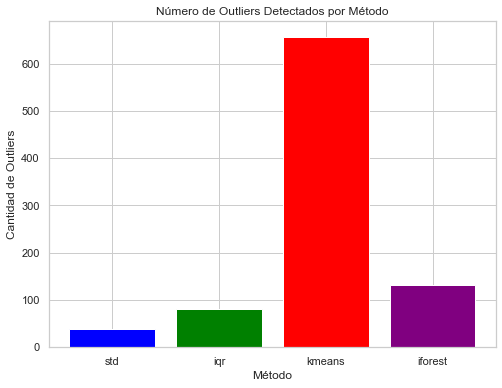

In [29]:
import matplotlib.pyplot as plt

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(counts.keys(), counts.values(), color=['blue', 'green', 'red', 'purple'])

plt.title('Número de Outliers Detectados por Método')
plt.xlabel('Método')
plt.ylabel('Cantidad de Outliers')
plt.show()


In [30]:
print(w_outliers_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   anyo              563 non-null    int32  
 1   isla              563 non-null    int32  
 2   entidad           563 non-null    int32  
 3   ADR               563 non-null    float64
 4   RevPAR            563 non-null    float64
 5   ingresos_totales  563 non-null    float64
 6   tasa_ocup_h       563 non-null    float64
 7   tasa_ocup_p       563 non-null    float64
 8   pernoctaciones    563 non-null    float64
 9   alojados          563 non-null    float64
 10  entrados          563 non-null    float64
dtypes: float64(8), int32(3)
memory usage: 41.9 KB
None


## Enfoque de PCA

In [40]:
# Copia de 'encoded_df' para testear con PCA, no se incluye 'RevPAR' al ser la variable objetivo
test_df = encoded_df.drop('RevPAR', axis=1).copy()

In [41]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [42]:
# Media de cada variable
test_df.mean(axis=0)

anyo                2.014000e+03
isla                3.578125e+00
entidad             3.150000e+01
ADR                 6.675733e+01
ingresos_totales    9.249858e+07
tasa_ocup_h         7.289545e+01
tasa_ocup_p         6.333675e+01
pernoctaciones      2.831162e+06
alojados            3.597499e+05
entrados            3.516684e+05
dtype: float64

In [43]:
# Varianza de cada variable
test_df.var(axis=0)

anyo                1.001422e+01
isla                1.089194e+00
entidad             3.417354e+02
ADR                 4.266808e+02
ingresos_totales    1.114942e+16
tasa_ocup_h         1.003912e+02
tasa_ocup_p         1.438524e+02
pernoctaciones      8.664862e+12
alojados            1.289502e+11
entrados            1.230237e+11
dtype: float64

In [44]:
# Entrenamiento modelo PCA con escalado de los datos
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(test_df)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [45]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = test_df.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10']
)

,anyo,isla,entidad,ADR,ingresos_totales,tasa_ocup_h,tasa_ocup_p,pernoctaciones,alojados,entrados
PC1,0.172924,-0.018096,-0.065930,0.209600,0.451631,0.278660,0.256140,0.435722,0.438293,0.438527
PC2,-0.466355,0.127965,0.045359,-0.332090,0.157543,-0.463657,-0.469041,0.257903,0.252987,0.251959
PC3,-0.193766,-0.693043,-0.655622,-0.212306,-0.043705,0.043220,0.053384,0.022139,0.007640,0.007447
PC4,-0.108016,-0.416910,0.673251,-0.482858,-0.092168,0.202608,0.262142,0.065112,0.052986,0.052805
PC5,0.038945,-0.560985,0.327671,0.621287,0.119297,-0.310160,-0.279966,-0.039488,-0.004891,-0.004317
PC6,-0.830047,0.116167,0.037400,0.364755,0.046516,0.170721,0.344129,-0.042233,-0.075744,-0.076336
PC7,0.108134,0.021221,-0.036903,-0.029842,-0.015110,-0.733615,0.667658,0.006239,0.026275,0.026251
PC8,0.018161,-0.022529,0.017841,-0.213988,0.856668,-0.019409,0.013179,-0.161311,-0.310572,-0.310077
PC9,-0.029675,0.004327,-0.006332,-0.042815,0.101458,0.023236,0.008842,-0.842096,0.355851,0.388021
PC10,0.000101,-0.000134,-0.000060,-0.000582,0.002616,0.000689,0.000279,-0.019343,0.715188,-0.698659


Influencia de las variables en cada componente

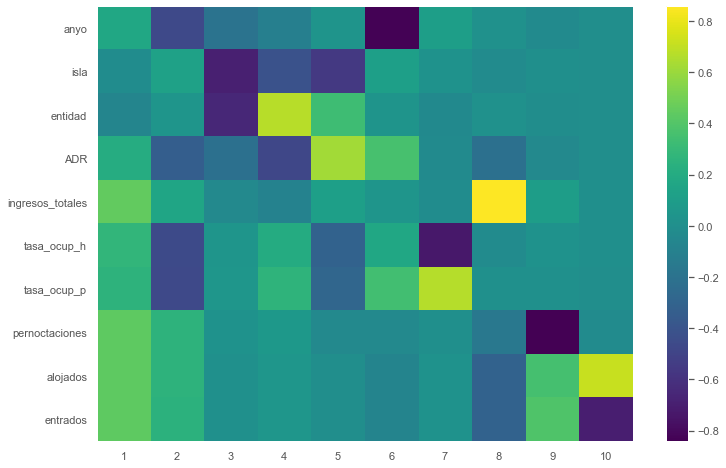

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una figura para el mapa de calor con dimensiones específicas.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# Obtener los componentes del modelo PCA.
componentes = modelo_pca.components_

# Crear un mapa de calor para visualizar los componentes del PCA.
plt.imshow(componentes.T, cmap='viridis', aspect='auto')

# Configurar las etiquetas del eje y para mostrar los nombres de las columnas del DataFrame 'test_df'.
plt.yticks(range(len(test_df.columns)), test_df.columns)

# Configurar las etiquetas del eje x para mostrar el número de cada componente principal.
plt.xticks(range(len(test_df.columns)), np.arange(modelo_pca.n_components_) + 1)

# Desactivar la cuadrícula para una visualización clara del mapa de calor.
plt.grid(False)

# Añadir una barra de colores para interpretar los valores en el mapa de calor.
plt.colorbar()

# Mostrar el gráfico resultante.
plt.show()


[4.41211297e-01 2.23043417e-01 1.27169644e-01 7.89733633e-02
 6.59505324e-02 4.69626099e-02 1.22549248e-02 3.40989691e-03
 1.02372679e-03 5.88588562e-07]


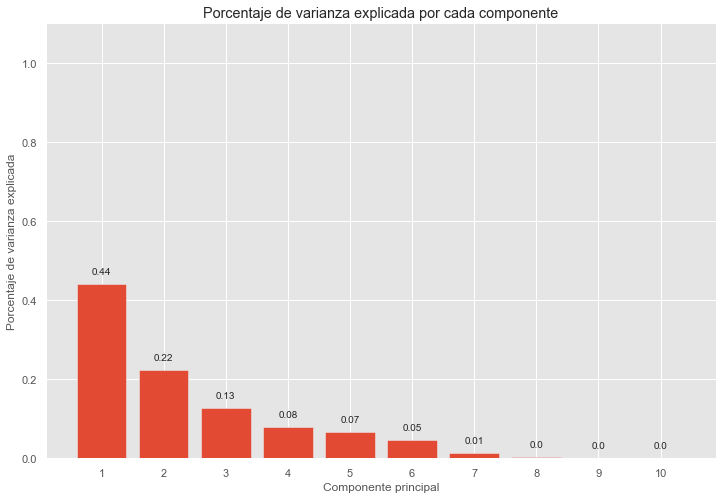

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Imprimir el porcentaje de varianza explicada por cada componente principal del modelo PCA.
print(modelo_pca.explained_variance_ratio_)

# Crear una figura para el gráfico de barras con dimensiones específicas.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# Crear un gráfico de barras para mostrar el porcentaje de varianza explicada por cada componente.
# El eje x muestra los números de los componentes principales.
# El eje y muestra el porcentaje de varianza explicada por cada componente.
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,  # Números de componentes
    height = modelo_pca.explained_variance_ratio_  # Porcentajes de varianza
)

# Añadir anotaciones para mostrar los valores de varianza en cada barra.
for x, y in zip(np.arange(len(test_df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)  # Redondear el valor de varianza a dos decimales.
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),  # Desplazar el texto para una mejor visualización.
        ha='center'
    )

# Configurar las etiquetas y límites de los ejes.
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)  # Etiquetas del eje x
ax.set_ylim(0, 1.1)  # Limitar el eje y para mejorar la visualización

# Añadir títulos y etiquetas a los ejes.
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Porcentaje de varianza explicada')

# Mostrar el gráfico resultante.
plt.show()

[0.4412113  0.66425471 0.79142436 0.87039772 0.93634825 0.98331086
 0.99556579 0.99897568 0.99999941 1.        ]


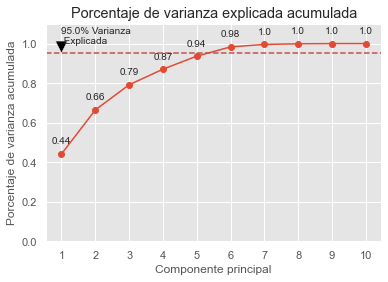

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular el porcentaje de varianza explicada acumulada por los componentes del PCA.
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print(prop_varianza_acum)

# Crear una figura para el gráfico con dimensiones específicas.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

# Crear un gráfico de líneas para mostrar la varianza explicada acumulada.
ax.plot(
    np.arange(len(test_df.columns)) + 1,  # Números de componentes
    prop_varianza_acum,                   # Varianza acumulada
    marker = 'o'
)

# Añadir anotaciones para mostrar los valores de varianza en cada punto.
for x, y in zip(np.arange(len(test_df.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)  # Redondear el valor de varianza a dos decimales.
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),  # Desplazar el texto para una mejor visualización.
        ha='center'
    )

# Configurar los límites y etiquetas de los ejes.
ax.set_ylim(0, 1.1)  # Límite superior para incluir 100% de varianza
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)  # Etiquetas del eje x
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Porcentaje de varianza acumulada')

# Marcar un umbral de varianza explicada (por ejemplo, 95%).
umbral_varianza = 0.95
ax.axhline(y=umbral_varianza, color='r', linestyle='--')
ax.annotate(f'{umbral_varianza*100}% Varianza\n Explicada', xy=(1, umbral_varianza), xytext=(1, umbral_varianza+0.05), arrowprops=dict(facecolor='black', shrink=0.05))

# Mostrar el gráfico resultante.
plt.show()


### Plot PCA

In [72]:
# Aplicar la transformación PCA al DataFrame 'test_df'.
# Esto proyecta los datos originales en el espacio definido por los componentes principales.
proyecciones = pca_pipe.transform(test_df)

# Convertir las proyecciones a un DataFrame de pandas para facilitar su manipulación y visualización.
# Las columnas representan los principales componentes (PC1, PC2, ..., PC10).
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
    index   = test_df.index  # Mantener el mismo índice que el DataFrame original para la trazabilidad.
)

# Mostrar las primeras filas del DataFrame 'proyecciones' para revisión.
proyecciones.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.669729,1.664689,3.482764,-0.289531,2.445214,-0.053212,-0.113077,0.040796,0.013871,0.001809
1,-1.100702,1.321734,3.509087,0.433497,1.822770,0.142607,-0.018481,0.034083,-0.037843,0.003963
2,-1.110899,1.380879,3.473333,0.460270,1.855706,0.115454,-0.005334,0.034520,-0.039854,0.004088
3,-2.243890,0.547090,1.352957,1.351287,2.155445,0.895939,1.177131,0.058725,-0.050953,-0.000526
4,-2.367777,0.837274,1.003336,2.067467,2.068813,0.676202,1.039200,0.205111,-0.037613,0.001427


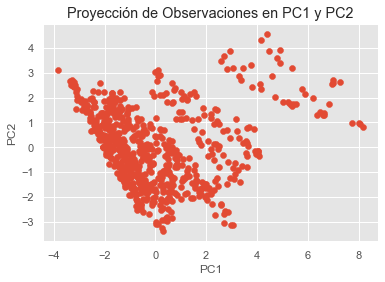

In [73]:
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión para visualizar las proyecciones de las observaciones.
# Se utiliza PC1 (Primer Componente Principal) en el eje x y PC2 (Segundo Componente Principal) en el eje y.
plt.scatter(proyecciones['PC1'], proyecciones['PC2'])

# Etiquetar los ejes para indicar que representan los dos primeros componentes principales.
plt.xlabel('PC1')
plt.ylabel('PC2')

# Añadir un título al gráfico para proporcionar contexto.
plt.title('Proyección de Observaciones en PC1 y PC2')

# Mostrar el gráfico resultante.
plt.show()


In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

def plot_pca_ii(data, feature_names):
    """
    Visualiza un análisis de componentes principales (PCA) de los datos con vectores de carga.

    Args:
        data (pd.DataFrame): DataFrame de entrada con los datos.
        feature_names (list): Lista de nombres de las variables (características).

    """

    # Estandarizar los datos para el análisis PCA.
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Realizar PCA en los datos escalados.
    pca = PCA()
    pca_result = pca.fit_transform(data_scaled)
    
    # Obtener los dos primeros componentes principales para la visualización.
    pca1 = pca_result[:, 0]
    pca2 = pca_result[:, 1]
    
    # Crear la figura para el gráfico.
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Dibujar los puntos de los dos componentes principales.
    scatter = ax.scatter(pca1, pca2, cmap='viridis', alpha=0.5)
    
    # Calcular el rango de los componentes para dimensionar correctamente los vectores de carga.
    x_scale = np.abs(pca1).max() + 1
    y_scale = np.abs(pca2).max() + 1
    
    # Dibujar los vectores de carga para cada variable en los componentes principales.
    for i, v in enumerate(pca.components_.T):
        ax.arrow(0, 0, v[0]*x_scale, v[1]*y_scale,
                 head_width=0.1, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*x_scale*1.2, v[1]*y_scale*1.2, feature_names[i], color='red',
                ha='center', va='center', fontsize=9)
    
    # Etiquetar los ejes con la varianza explicada por cada componente principal.
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% de var. explicada)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% de var. explicada)")
    
    # Mostrar la cuadrícula para facilitar la interpretación del gráfico.
    ax.grid(True)
    
    # Mostrar el gráfico resultante.
    plt.show()


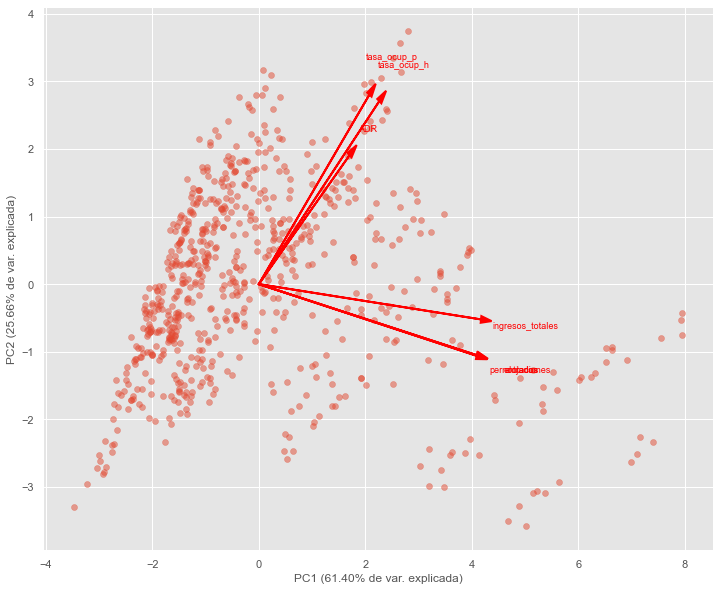

In [75]:
# Seleccionar solo las columnas numéricas para el análisis PCA, excluyendo la variable objetivo "RevPAR".
numeric_columns = ['ADR', 'ingresos_totales', 'tasa_ocup_h', 'tasa_ocup_p', 'pernoctaciones', 'alojados', 'entrados']

# Crear un DataFrame 'numeric_df' que solo contenga las columnas numéricas seleccionadas.
numeric_df = test_df[numeric_columns]

# Utilizar la función 'plot_pca_ii' para visualizar el análisis PCA de las columnas seleccionadas.
plot_pca_ii(numeric_df, numeric_columns)


#### Interpretación de los Componentes Principales:

PC1 (Eje X): Representa la dirección de máxima varianza y aquí captura el 55.52% de la varianza total de los datos. Las variables que tienen vectores de carga más largos en la dirección positiva de PC1 tienen mayor influencia en este componente. En tu gráfico, parece que **ingresos_totales**, **pernoctaciones**, y **tasa_ocup_p** tienen la mayor influencia positiva en PC1.

PC2 (Eje Y): Es ortogonal a PC1 y representa la segunda dirección más significativa de varianza, capturando el 28.18% de la varianza. Las variables **ADR** y **RevPAR** parecen tener la mayor influencia en PC2, dada la longitud de sus vectores de carga en la dirección positiva.

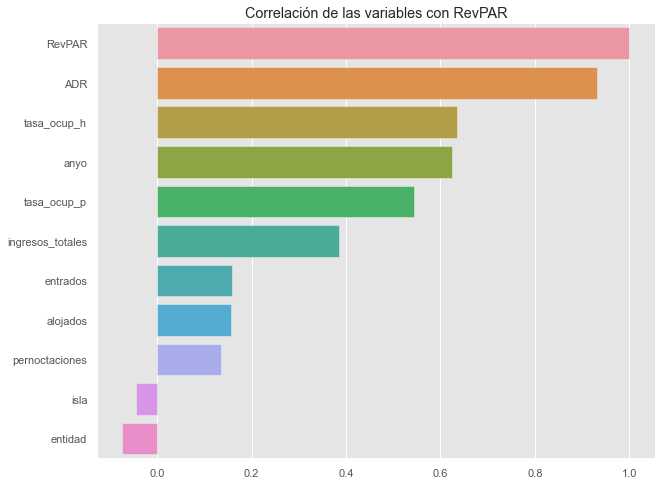

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación para el DataFrame 'w_outliers_df'.
correlations = w_outliers_df.corr()

# Extraer la correlación de cada variable con 'RevPAR'.
# Ordenar los valores de correlación en orden descendente para mejor visualización.
correlation_with_target = correlations['RevPAR'].sort_values(ascending=False)

# Crear un gráfico de barras para visualizar la correlación de cada variable con 'RevPAR'.
# Configurar el tamaño del gráfico.
plt.figure(figsize=(10, 8))

# Utilizar Seaborn para crear el gráfico de barras.
# Las barras representan la magnitud de la correlación de cada variable con 'RevPAR'.
sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index)

# Añadir un título al gráfico para proporcionar contexto.
plt.title('Correlación de las variables con RevPAR')

# Mostrar el gráfico resultante.
plt.show()


## Análisis Exploratorio de Datos

In [77]:
train_df = w_outliers_df.copy()
print(train_df)

     anyo  isla  entidad    ADR  RevPAR  ingresos_totales  tasa_ocup_h  \
0    2009     0        8  57.58   35.00       67969665.09        60.79   
1    2009     0        9  57.23   34.49       68649877.70        60.28   
2    2009     1       48  67.35   36.12        9696842.87        53.59   
3    2009     1       61  55.88   30.19       14690544.38        54.08   
4    2009     2       12  48.29   29.88       76675318.03        84.29   
..    ...   ...      ...    ...     ...               ...          ...   
558  2019     4       58  94.61   66.05       53638349.20        69.97   
559  2019     4       59  60.47   43.54       35966571.46        72.20   
560  2019     4       60  59.74   46.41       83054987.35        77.89   
561  2019     4       62  61.37   35.26       11078435.43        57.65   
562  2019     4       63  64.21   51.14       30303315.42        79.86   

     tasa_ocup_p  pernoctaciones  alojados  entrados  
0          50.46       2582224.0  309624.0  299828.0  
1

### Preparación de los datos

In [78]:
# Aplicar One-Hot Encoding a la variable 'isla' utilizando pd.get_dummies
train_df_encoded = pd.get_dummies(train_df, columns=['isla'])

# Mostrar el DataFrame resultante
train_df_encoded.head()

,anyo,entidad,ADR,RevPAR,ingresos_totales,tasa_ocup_h,tasa_ocup_p,pernoctaciones,alojados,entrados,isla_0,isla_1,isla_2,isla_3,isla_4
0,2009,8,57.58,35.00,67969665.09,60.79,50.46,2582224.0,309624.0,299828.0,1,0,0,0,0
1,2009,9,57.23,34.49,68649877.70,60.28,50.04,2621379.0,314331.0,304332.0,1,0,0,0,0
2,2009,48,67.35,36.12,9696842.87,53.59,64.37,475472.0,55682.0,54045.0,0,1,0,0,0
3,2009,61,55.88,30.19,14690544.38,54.08,62.69,583444.0,65914.0,63140.0,0,1,0,0,0
4,2009,12,48.29,29.88,76675318.03,84.29,57.28,3742345.0,471054.0,462066.0,0,0,1,0,0


Se eliminan las columnas de tasa de ocupación, al no tener una influencia significativa en los componentes principales, y también ingresos_totales, por la posible existencia de multicolinealidad, es decir, una fuerte correlación entre variables explicativas del modelo, pudiendo distorcionar las estimaciones.

In [79]:
# Eliminar columnas 'tasa_ocup_h', 'tasa_ocup_p', e 'ingresos_totales' de 'df_train'
train_df_encoded.drop(columns=['ingresos_totales'], inplace=True)

#### Estandarización

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Crear una instancia del StandardScaler
scaler = StandardScaler()

# Seleccionar las columnas numéricas que deseas estandarizar
columnas_para_estandarizar = ['ADR', 'pernoctaciones', 'alojados', 'entrados']

# Aplicar el scaler a las columnas seleccionadas
train_df_encoded[columnas_para_estandarizar] = scaler.fit_transform(train_df[columnas_para_estandarizar])


#### Conjunto de entrenamiento y prueba

In [82]:
from sklearn.model_selection import train_test_split
# Definir las variables independientes (X) y dependiente (y)
X = train_df_encoded.drop('RevPAR', axis=1)
y = train_df_encoded['RevPAR']

# Dividir los datos en conjuntos de entrenamiento y prueba
train_mask = (X['anyo'] >= 2009) & (X['anyo'] <= 2017)
test_mask = (X['anyo'] >= 2018) & (X['anyo'] <= 2019)

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]


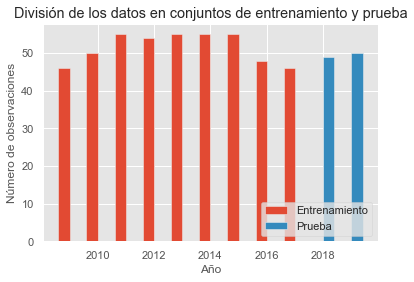

In [83]:
# Crea una serie que contiene el conteo de observaciones para cada año en los conjuntos de entrenamiento y prueba
train_counts = X_train['anyo'].value_counts().sort_index()
test_counts = X_test['anyo'].value_counts().sort_index()

# Crea una figura y un conjunto de ejes
fig, ax = plt.subplots()

# Dibuja las barras para el conjunto de entrenamiento
ax.bar(train_counts.index - 0.2, train_counts.values, width=0.4, align='center', label='Entrenamiento')

# Dibuja las barras para el conjunto de prueba
ax.bar(test_counts.index + 0.2, test_counts.values, width=0.4, align='center', label='Prueba')

# Agrega etiquetas y un título
ax.set_xlabel('Año')
ax.set_ylabel('Número de observaciones')
ax.set_title('División de los datos en conjuntos de entrenamiento y prueba')

# Coloca la leyenda en la esquina inferior derecha
ax.legend(loc='lower right')

# Muestra la gráfica
plt.show()


#### Selección del modelo

In [84]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Crear instancias de los modelos
model_lr = LinearRegression()
model_ridge = Ridge()
model_rf = RandomForestRegressor()
model_gbm = GradientBoostingRegressor()

# Evaluar modelos usando cross-validation
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=5)
scores_ridge = cross_val_score(model_ridge, X_train, y_train, cv=5)
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
scores_gbm = cross_val_score(model_gbm, X_train, y_train, cv=5)

# Imprimir los resultados
print("Linear Regression:", scores_lr.mean())
print("Ridge Regression:", scores_ridge.mean())
print("Random Forest:", scores_rf.mean())
print("Gradient Boosting:", scores_gbm.mean())


Linear Regression: 0.979168949192727
Ridge Regression: 0.9786197433190107
Random Forest: 0.9620011534785469
Gradient Boosting: 0.9732991660952834


#### Evaluar Modelo 

Para evaluar los diferentes modelos de regresión y obtener, así, una comprensión mas completa de su rendimiento

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para calcular y mostrar las métricas
# Función para calcular y mostrar las métricas, incluyendo R²
def evaluate_model(model, X_test, y_test, nombre_modelo):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{nombre_modelo} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

In [86]:
# Entrenar cada modelo
model_lr.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_gbm.fit(X_train, y_train)

# Evaluar cada modelo
evaluate_model(model_lr, X_test, y_test, "Linear Regression")
evaluate_model(model_ridge, X_test, y_test, "Ridge Regression")
evaluate_model(model_rf, X_test, y_test, "Random Forest")
evaluate_model(model_gbm, X_test, y_test, "Gradient Boosting")

Linear Regression - MSE: 2.3742, MAE: 1.2834, R²: 0.9869
Ridge Regression - MSE: 2.5125, MAE: 1.3269, R²: 0.9861
Random Forest - MSE: 3.7501, MAE: 1.4193, R²: 0.9793
Gradient Boosting - MSE: 2.3064, MAE: 1.1837, R²: 0.9873


Basándose en estos resultados, el modelo **Gradient Boosting** parece ser el más adecuado para tus necesidades de predicción, seguido de cerca por **Random Forest**.

#### Redes Neuronales

In [87]:
# Importar librerías necesarias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Crear un modelo secuencial
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))  # Dropout para prevenir sobreajuste
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Capa de salida para regresión

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Realizar predicciones con el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados de las métricas
print(f"Red Neuronal - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Epoch 1/50
15/15 [==============================] - 1s 2ms/step - loss: 15058.9756
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 5177.3765
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 3007.5171
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 2291.2571
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 1907.0464
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 1379.3403
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 1162.4691
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 1044.4417
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 825.7192
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 718.0181
Epoch 11/50
15/15 [==============================] - 0s 2ms/step - loss: 677.6902
Epoch 12/50
15/15 [==============================] - 0s 2ms/step - loss: 606.2328
Epoch 13/50
15/1

Dado que los modelos más simples como Gradient Boosting y Random Forest proporcionaron resultados significativamente mejores, puede que sean más adecuados para este problema específico. En algunos casos, pueden no ser la mejor herramienta, especialmente si el conjunto de datos no es lo suficientemente grande o si la relación en los datos no es lo suficientemente compleja para justificar su uso.

## Prueba con modelo base, sin transformar

In [88]:
train_df = encoded_df.copy()
print(train_df)

     anyo  isla  entidad    ADR  RevPAR  ingresos_totales  tasa_ocup_h  \
0    2009     0        4  66.58   36.33       61891895.02        54.57   
1    2009     0        8  57.58   35.00       67969665.09        60.79   
2    2009     0        9  57.23   34.49       68649877.70        60.28   
3    2009     1       48  67.35   36.12        9696842.87        53.59   
4    2009     1       61  55.88   30.19       14690544.38        54.08   
..    ...   ...      ...    ...     ...               ...          ...   
699  2019     4       58  94.61   66.05       53638349.20        69.97   
700  2019     4       59  60.47   43.54       35966571.46        72.20   
701  2019     4       60  59.74   46.41       83054987.35        77.89   
702  2019     4       62  61.37   35.26       11078435.43        57.65   
703  2019     4       63  64.21   51.14       30303315.42        79.86   

     tasa_ocup_p  pernoctaciones  alojados  entrados  
0          40.85       1792019.0  246084.0  239461.0  
1

In [90]:
# Aplicar One-Hot Encoding a la variable 'isla' utilizando pd.get_dummies
train_df_encoded = pd.get_dummies(train_df, columns=['isla'])

# Mostrar el DataFrame resultante
train_df_encoded.head()

,anyo,entidad,ADR,RevPAR,ingresos_totales,tasa_ocup_h,tasa_ocup_p,pernoctaciones,alojados,entrados,isla_0,isla_1,isla_2,isla_3,isla_4
0,2009,4,66.58,36.33,61891895.02,54.57,40.85,1792019.0,246084.0,239461.0,1,0,0,0,0
1,2009,8,57.58,35.00,67969665.09,60.79,50.46,2582224.0,309624.0,299828.0,1,0,0,0,0
2,2009,9,57.23,34.49,68649877.70,60.28,50.04,2621379.0,314331.0,304332.0,1,0,0,0,0
3,2009,48,67.35,36.12,9696842.87,53.59,64.37,475472.0,55682.0,54045.0,0,1,0,0,0
4,2009,61,55.88,30.19,14690544.38,54.08,62.69,583444.0,65914.0,63140.0,0,1,0,0,0


In [91]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Crear una instancia del StandardScaler
scaler = StandardScaler()

# Seleccionar las columnas numéricas que deseas estandarizar
columns_to_standardise = ['ADR', 'pernoctaciones', 'alojados', 'entrados', 'ingresos_totales', 'tasa_ocup_h', 'tasa_ocup_p']

# Aplicar el scaler a las columnas seleccionadas
train_df_encoded[columns_to_standardise] = scaler.fit_transform(train_df[columns_to_standardise])

In [92]:
from sklearn.model_selection import train_test_split
# Definir las variables independientes (X) y dependiente (y)
X = train_df_encoded.drop('RevPAR', axis=1)
y = train_df_encoded['RevPAR']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Crear instancias de los modelos
model_lr = LinearRegression()
model_ridge = Ridge()
model_rf = RandomForestRegressor()
model_gbm = GradientBoostingRegressor()

# Evaluar modelos usando cross-validation
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=5)
scores_ridge = cross_val_score(model_ridge, X_train, y_train, cv=5)
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
scores_gbm = cross_val_score(model_gbm, X_train, y_train, cv=5)

# Imprimir los resultados
print("Linear Regression:", scores_lr.mean())
print("Ridge Regression:", scores_ridge.mean())
print("Random Forest:", scores_rf.mean())
print("Gradient Boosting:", scores_gbm.mean())

Linear Regression: 0.990908039373225
Ridge Regression: 0.9907516297319017
Random Forest: 0.9927591922474053
Gradient Boosting: 0.9937760413364799


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para calcular y mostrar las métricas
# Función para calcular y mostrar las métricas, incluyendo R²
def evaluate_model(model, X_test, y_test, nombre_modelo):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{nombre_modelo} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

In [95]:
# Entrenar cada modelo
model_lr.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_gbm.fit(X_train, y_train)

# Evaluar cada modelo
evaluate_model(model_lr, X_test, y_test, "Linear Regression")
evaluate_model(model_ridge, X_test, y_test, "Ridge Regression")
evaluate_model(model_rf, X_test, y_test, "Random Forest")
evaluate_model(model_gbm, X_test, y_test, "Gradient Boosting")

Linear Regression - MSE: 3.7681, MAE: 1.3396, R²: 0.9888
Ridge Regression - MSE: 3.8247, MAE: 1.3476, R²: 0.9886
Random Forest - MSE: 2.2436, MAE: 0.8708, R²: 0.9933
Gradient Boosting - MSE: 2.5508, MAE: 0.9530, R²: 0.9924


### Prueba con base sin outliers

In [97]:
train_df = w_outliers_df.copy()
print(train_df)

     anyo  isla  entidad    ADR  RevPAR  ingresos_totales  tasa_ocup_h  \
0    2009     0        8  57.58   35.00       67969665.09        60.79   
1    2009     0        9  57.23   34.49       68649877.70        60.28   
2    2009     1       48  67.35   36.12        9696842.87        53.59   
3    2009     1       61  55.88   30.19       14690544.38        54.08   
4    2009     2       12  48.29   29.88       76675318.03        84.29   
..    ...   ...      ...    ...     ...               ...          ...   
558  2019     4       58  94.61   66.05       53638349.20        69.97   
559  2019     4       59  60.47   43.54       35966571.46        72.20   
560  2019     4       60  59.74   46.41       83054987.35        77.89   
561  2019     4       62  61.37   35.26       11078435.43        57.65   
562  2019     4       63  64.21   51.14       30303315.42        79.86   

     tasa_ocup_p  pernoctaciones  alojados  entrados  
0          50.46       2582224.0  309624.0  299828.0  
1

In [98]:
# Aplicar One-Hot Encoding a la variable 'isla' utilizando pd.get_dummies
train_df_encoded = pd.get_dummies(train_df, columns=['isla'])

# Mostrar el DataFrame resultante
train_df_encoded.head()

,anyo,entidad,ADR,RevPAR,ingresos_totales,tasa_ocup_h,tasa_ocup_p,pernoctaciones,alojados,entrados,isla_0,isla_1,isla_2,isla_3,isla_4
0,2009,8,57.58,35.00,67969665.09,60.79,50.46,2582224.0,309624.0,299828.0,1,0,0,0,0
1,2009,9,57.23,34.49,68649877.70,60.28,50.04,2621379.0,314331.0,304332.0,1,0,0,0,0
2,2009,48,67.35,36.12,9696842.87,53.59,64.37,475472.0,55682.0,54045.0,0,1,0,0,0
3,2009,61,55.88,30.19,14690544.38,54.08,62.69,583444.0,65914.0,63140.0,0,1,0,0,0
4,2009,12,48.29,29.88,76675318.03,84.29,57.28,3742345.0,471054.0,462066.0,0,0,1,0,0


In [99]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Crear una instancia del StandardScaler
scaler = StandardScaler()

# Seleccionar las columnas numéricas que deseas estandarizar
columns_to_standardise = ['ADR', 'pernoctaciones', 'alojados', 'entrados', 'ingresos_totales', 'tasa_ocup_h', 'tasa_ocup_p']

# Aplicar el scaler a las columnas seleccionadas
train_df_encoded[columns_to_standardise] = scaler.fit_transform(train_df[columns_to_standardise])

In [100]:
from sklearn.model_selection import train_test_split
# Definir las variables independientes (X) y dependiente (y)
X = train_df_encoded.drop('RevPAR', axis=1)
y = train_df_encoded['RevPAR']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Crear instancias de los modelos
model_lr = LinearRegression()
model_ridge = Ridge()
model_rf = RandomForestRegressor()
model_gbm = GradientBoostingRegressor()

# Evaluar modelos usando cross-validation
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=5)
scores_ridge = cross_val_score(model_ridge, X_train, y_train, cv=5)
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5)
scores_gbm = cross_val_score(model_gbm, X_train, y_train, cv=5)

# Imprimir los resultados
print("Linear Regression:", scores_lr.mean())
print("Ridge Regression:", scores_ridge.mean())
print("Random Forest:", scores_rf.mean())
print("Gradient Boosting:", scores_gbm.mean())

Linear Regression: 0.9905839828509955
Ridge Regression: 0.9903648025397496
Random Forest: 0.9887502808067635
Gradient Boosting: 0.9925312168243907


In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para calcular y mostrar las métricas
# Función para calcular y mostrar las métricas, incluyendo R²
def evaluate_model(model, X_test, y_test, nombre_modelo):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{nombre_modelo} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

In [103]:
# Entrenar cada modelo
model_lr.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_gbm.fit(X_train, y_train)

# Evaluar cada modelo
evaluate_model(model_lr, X_test, y_test, "Linear Regression")
evaluate_model(model_ridge, X_test, y_test, "Ridge Regression")
evaluate_model(model_rf, X_test, y_test, "Random Forest")
evaluate_model(model_gbm, X_test, y_test, "Gradient Boosting")

Linear Regression - MSE: 1.6840, MAE: 0.9735, R²: 0.9932
Ridge Regression - MSE: 1.7372, MAE: 0.9892, R²: 0.9930
Random Forest - MSE: 2.0556, MAE: 0.9267, R²: 0.9917
Gradient Boosting - MSE: 0.9317, MAE: 0.7276, R²: 0.9962
